In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns

import requests
import json
import time
import gmaps
import os

# Import API key
from api_keys import g_key
from api_keys import weather_api_key
gmaps.configure(api_key=g_key)

In [2]:
#import csv file
stockx_csv = "Resources/StockX_Data_Contest.csv"

stockx_df = pd.read_csv(stockx_csv)
stockx_df

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island
...,...,...,...,...,...,...,...,...
99951,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$565,$220,12/26/18,8.0,Oregon
99952,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$598,$220,12/26/18,8.5,California
99953,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$605,$220,12/26/18,5.5,New York
99954,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$650,$220,12/26/18,11.0,California


In [3]:
#Clean the data
#Get rid of Nike sales
shoe_brand = "Off-White"
yeezy_stockx = stockx_df[stockx_df["Brand"] != (shoe_brand)]

#Split Sneaker Name:
split = yeezy_stockx["Sneaker Name"].str.split("-", n=4, expand=True)
yeezy_stockx["Colorway"] = split[4]

#Clean up the '$' and ',' symbols
yeezy_stockx["Sale Price"] = yeezy_stockx["Sale Price"].str.replace(",", "")
yeezy_stockx["Sale Price"] = yeezy_stockx["Sale Price"].str.replace("$", "")
yeezy_stockx["Sale Price"] = yeezy_stockx["Sale Price"].astype('float')

yeezy_stockx["Retail Price"] = yeezy_stockx["Retail Price"].str.replace(",", "")
yeezy_stockx["Retail Price"] = yeezy_stockx["Retail Price"].str.replace("$", "")
yeezy_stockx["Retail Price"] = yeezy_stockx["Retail Price"].astype('float')

#Calculate profit of each sale
yeezy_stockx["Profit"] = yeezy_stockx["Sale Price"] - yeezy_stockx["Retail Price"]

#Reorder the columns
yeezy_stockx = yeezy_stockx[["Order Date", "Release Date", "Brand", "Sneaker Name", "Colorway", "Sale Price", "Retail Price", "Profit", "Shoe Size", "Buyer Region"]]

yeezy_stockx

<ipython-input-3-87ddb484a2fc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yeezy_stockx["Colorway"] = split[4]
<ipython-input-3-87ddb484a2fc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yeezy_stockx["Sale Price"] = yeezy_stockx["Sale Price"].str.replace(",", "")
<ipython-input-3-87ddb484a2fc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

,Order Date,Release Date,Brand,Sneaker Name,Colorway,Sale Price,Retail Price,Profit,Shoe Size,Buyer Region
0,9/1/17,9/24/16,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,Low-V2-Beluga,1097.0,220.0,877.0,11.0,California
1,9/1/17,11/23/16,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,V2-Core-Black-Copper,685.0,220.0,465.0,11.0,California
2,9/1/17,11/23/16,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,V2-Core-Black-Green,690.0,220.0,470.0,11.0,California
3,9/1/17,11/23/16,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,V2-Core-Black-Red,1075.0,220.0,855.0,11.5,Kentucky
4,9/1/17,2/11/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,V2-Core-Black-Red-2017,828.0,220.0,608.0,11.0,Rhode Island
...,...,...,...,...,...,...,...,...,...,...
99951,2/13/19,12/26/18,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,V2-Static-Reflective,565.0,220.0,345.0,8.0,Oregon
99952,2/13/19,12/26/18,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,V2-Static-Reflective,598.0,220.0,378.0,8.5,California
99953,2/13/19,12/26/18,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,V2-Static-Reflective,605.0,220.0,385.0,5.5,New York
99954,2/13/19,12/26/18,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,V2-Static-Reflective,650.0,220.0,430.0,11.0,California


# <b>Which shoes have the best/worst profit margins?<b>


In [4]:
#Group by colorways
colorway = yeezy_stockx.groupby(["Colorway"])

colorway_avg = colorway.mean().sort_values("Profit", ascending=False)
colorway_avg

,Sale Price,Retail Price,Profit,Shoe Size
Colorway,,,,
Low-Turtledove,1531.661765,200.0,1331.661765,10.411765
Low-Oxford-Tan,1011.514286,200.0,811.514286,9.900000
Low-Moonrock,996.710000,200.0,796.710000,9.610000
Low-Pirate-Black-2016,984.237705,200.0,784.237705,10.049180
V2-Core-Black-Red,937.754967,220.0,717.754967,9.750000
Low-Pirate-Black-2015,895.094737,200.0,695.094737,10.094737
V2-Core-Black-Red-2017,804.304438,220.0,584.304438,9.778122
Low-V2-Beluga,788.704819,220.0,568.704819,9.489960
V2-Core-Black-White,718.412238,220.0,498.412238,9.600644


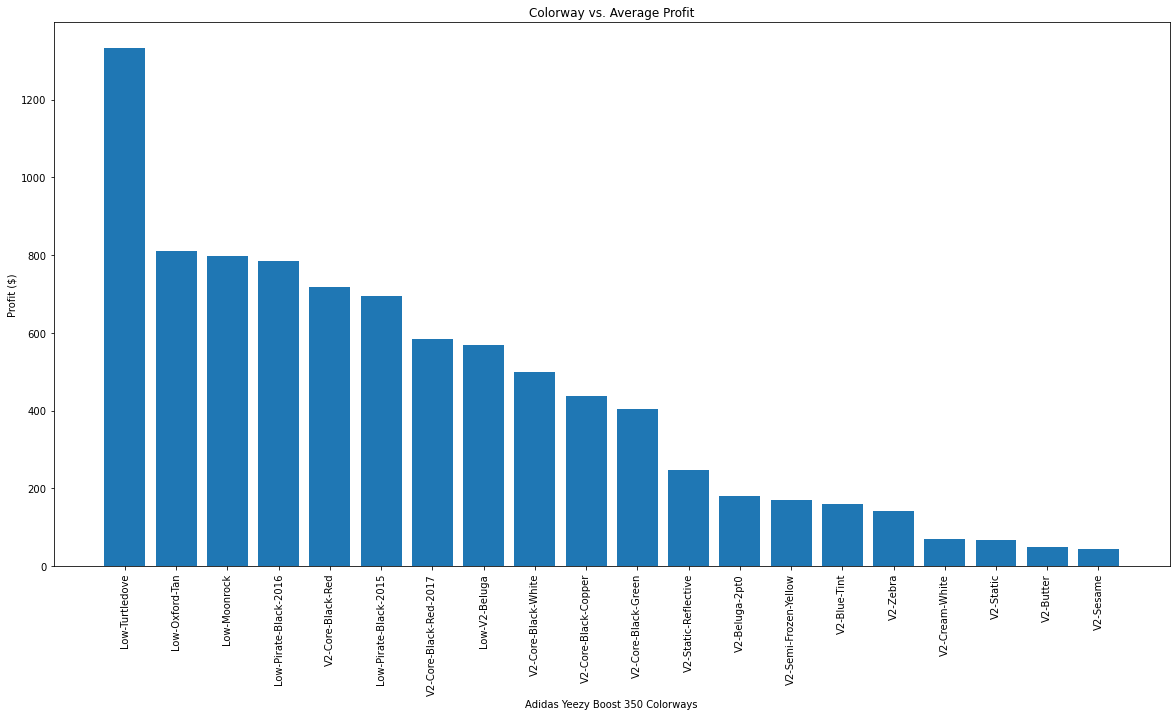

In [17]:
# bar graph to show colorway vs. avg proft
colorway_avg_noindex = colorway_avg.reset_index()

x_axis = colorway_avg_noindex["Colorway"]
y_axis = colorway_avg_noindex["Profit"]

plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.title("Colorway vs. Average Profit")
plt.xlabel("Adidas Yeezy Boost 350 Colorways")
plt.xticks(rotation=90)
plt.ylabel("Profit ($)")

plt.savefig("output_data/Fig1.jpg")
plt.show()

<b>Write-up:<b>

Looking at our graph, we can see that the colorway with the most average profit was the Low-Turtledove (~1332/unit).

The colorway with the least average profit was the V2-Sesame (~$44/unit).

Other than the Low-Turtledoves and Low-Oxford-Tans, the rest of the sneakers had an average profit of nearly less than $800.

Resellers should therefore be trying to find the top 50% of colorways shown in the graph in order to maximise their inventory for maximum profit.

# <b>Is there a significant difference in profit between shoe size and profit?<b>

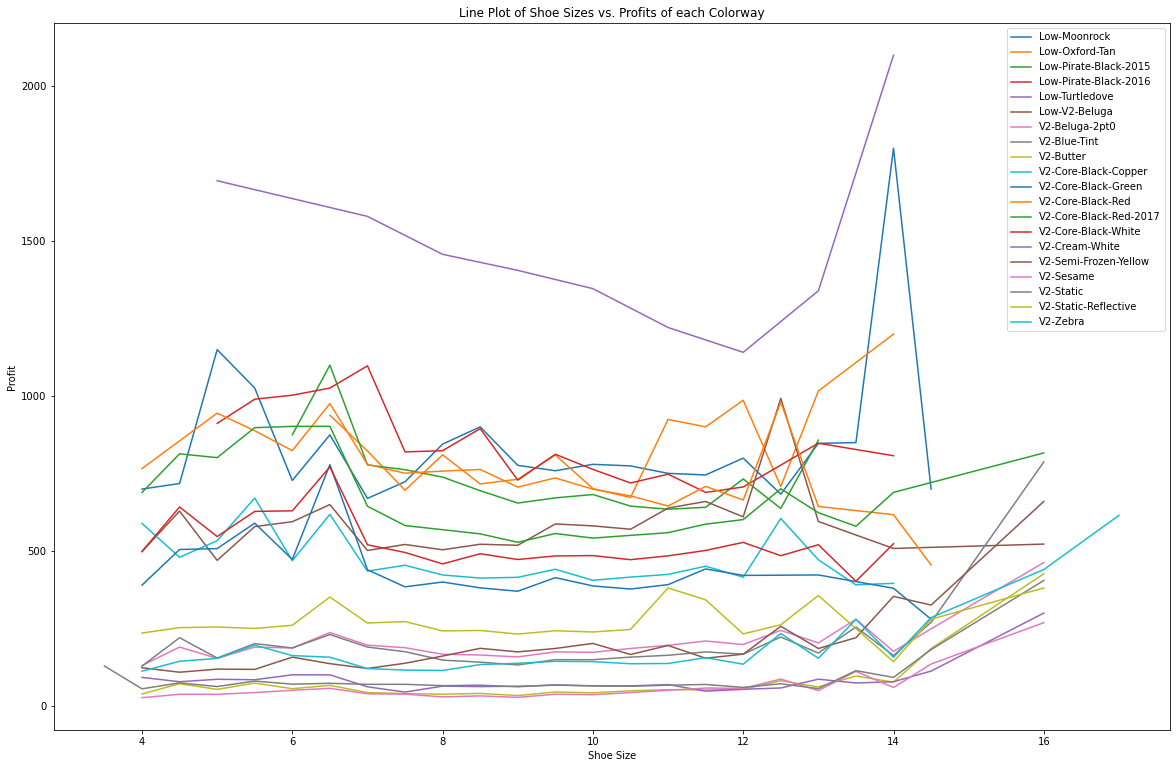

In [18]:
#Group by colorway and shoe size
colorway_ss = yeezy_stockx.groupby(["Colorway", "Shoe Size"])
colorway_ss_group = colorway_ss.mean()

colorway_ss_sort = colorway_ss_group.reset_index()

#Creating a dictionary to create and store a new database for each colorway
unique_colorway = colorway_ss_sort["Colorway"].unique()

total_dict = {}

for x in unique_colorway:
    specific_shoe_size_data = []
    specific_profit_data = []

    dict = {}

    for index, rows in colorway_ss_sort.iterrows():

        if x == rows["Colorway"]:
            specific_shoe_size_data.append(rows["Shoe Size"])
            specific_profit_data.append(rows["Profit"])

    for size in specific_shoe_size_data:

        for profit in specific_profit_data:
            dict[size] = profit
            specific_profit_data.remove(profit)
            break

    total_dict[x] = pd.DataFrame.from_dict(dict, orient='index')
    total_dict[x] = total_dict[x].reset_index()
    total_dict[x] = total_dict[x].rename(columns={"index": "Shoe Size", 0: "Profit"})

#Using each colorway database to create a line graph for each colorway

plt.figure(figsize=(20,13))
plt.title("Line Plot of Shoe Sizes vs. Profits of each Colorway")
plt.xlabel("Shoe Size")
plt.ylabel("Profit")
for x in unique_colorway:

    x_axis = total_dict[x][["Shoe Size"]]
    y_axis = total_dict[x][["Profit"]]

    plt.plot(x_axis, y_axis, label=x)
    plt.legend()


plt.savefig("output_data/Fig2.jpg")    


<b>Write-up:<b>

The impact of shoe sizes differ by colorway, but there is a slightly noticeable rise and fall of profits depending on the shoe sizes.

This is due to the demand of certain shoe sizes; size 10s and 10.5s are more highly sought for, so since there are lot more quantity demanded, they resale for less than size 7s and 13s.

To maximise profit, resellers should be looking for shoes that are higher and lovwer than NA size 10s since they generally do resell for a higher profit.


# <b>Does region impact profit?<b>

In [7]:
Buyer_Region = yeezy_stockx.groupby(["Buyer Region"])
Buyer_Region_Profit = Buyer_Region.mean().sort_values("Profit", ascending=False)
Buyer_Region_Profit.head()

,Sale Price,Retail Price,Profit,Shoe Size
Buyer Region,,,,
Kentucky,401.677582,219.697733,181.979849,10.236776
Delaware,389.711491,219.877751,169.833741,8.058068
Hawaii,383.084071,219.734513,163.349558,9.413717
Nevada,378.953789,219.815157,159.138632,9.440850
California,373.781286,219.803249,153.978037,9.000534


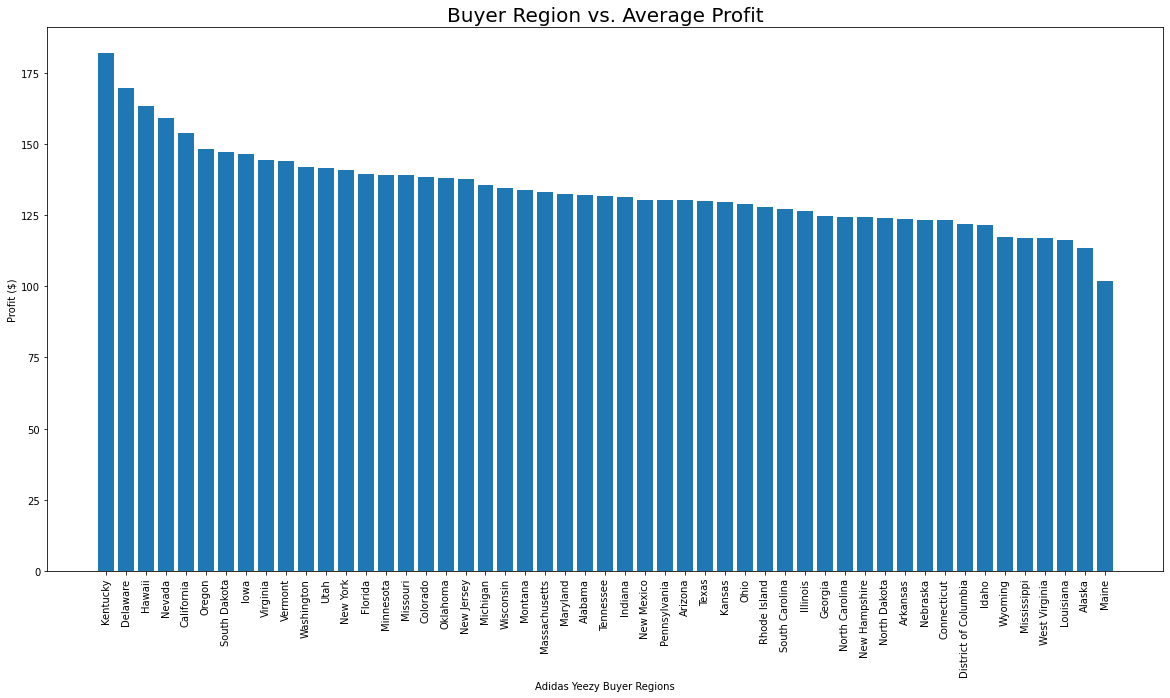

In [19]:
# bar graph to Buyer Region vs. avg profit
Buyer_Region_Profit_noindex = Buyer_Region_Profit.reset_index()

x_axis = Buyer_Region_Profit_noindex["Buyer Region"]
y_axis = Buyer_Region_Profit_noindex["Profit"]

plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.title('Buyer Region vs. Average Profit', fontsize = 20)
plt.xlabel("Adidas Yeezy Buyer Regions")
plt.xticks(rotation=90)
plt.ylabel("Profit ($)")

plt.savefig("output_data/Fig3.jpg")
plt.show()

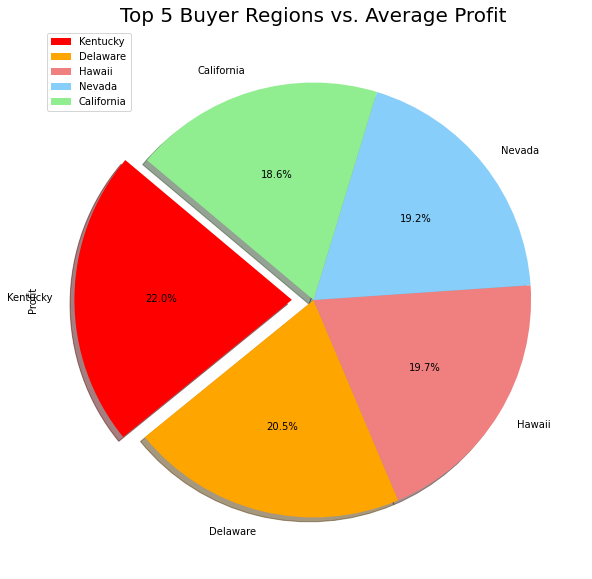

In [20]:
# The colors of each section of the pie chart
colors = ["red", "orange", "lightcoral", "lightskyblue", "lightgreen"]

# Tells matplotlib to seperate the "Humans" section from the others
explode = (0.1, 0, 0, 0, 0)


Buyer_Region_Profit.head().plot.pie(y='Profit', explode=explode, colors=colors, figsize=(10, 10),autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Top 5 Buyer Regions vs. Average Profit',fontsize = 20)

plt.savefig("output_data/Fig4.jpg")

<b>Write-ups:<b>

In order to showcase which Region has the best and worst average profit we utilized bar and pie charts to illustrate the data.

Based on our results, Kentucky produced the highest average profit of $182 and Maine had the worst average profit at $101.

As we further narrowed down to the top five buying regions, we saw it was predominantly split between the West and Southeast regions.

Overall, this buyer region analysis can help resellers direct their efforts and resources towards which geolocations are generating maximum profit.

An additional analysis could be done at the city level in order to further narrow down a resellers target market.

# <b>Does region impact number of Yeezy Sales? (API)<b>

In [10]:
#Creating a Latitude and Longitude Column
region_group = yeezy_stockx.groupby(["Buyer Region"])
region_count = region_group.count().sort_values("Profit", ascending=False)
region_count = region_count.reset_index()
region_count["Lat"] = ""
region_count["Lng"] = ""
region_count = region_count[["Buyer Region", "Lat", "Lng", "Profit"]]
region_count = region_count.rename(columns={"Profit": "Sales Records"})

region_count.head()

,Buyer Region,Lat,Lng,Sales Records
0,California,,,13113
1,New York,,,12103
2,Oregon,,,5396
3,Florida,,,4484
4,Texas,,,4455


In [11]:
#create a params dict that will be updated with new city each iteration
params = {"key": g_key}

#Loop through the region_count and get the lat/lng for each city
for index, row in region_count.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"

    state = row['Buyer Region']

    params['address'] = state

    region_lat_lng = requests.get(base_url, params=params).json()

    region_count.loc[index, "Lat"] = region_lat_lng["results"][0]["geometry"]["location"]["lat"]
    region_count.loc[index, "Lng"] = region_lat_lng["results"][0]["geometry"]["location"]["lng"]

region_count.head()


,Buyer Region,Lat,Lng,Sales Records
0,California,36.7783,-119.418,13113
1,New York,40.7128,-74.006,12103
2,Oregon,43.8041,-120.554,5396
3,Florida,27.6648,-81.5158,4484
4,Texas,31.9686,-99.9018,4455


In [22]:
#Store variables for gmaps
buyer_region = region_count[["Lat", "Lng"]]
no_sales = region_count["Sales Records"].astype(float)

#Create heatmap
fig = gmaps.figure(zoom_level=4, center=(37, -100))
heat_layer = gmaps.heatmap_layer(buyer_region, weights=no_sales, 
                                 dissipating=False, max_intensity=6000,
                                 point_radius=3)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [13]:
# NOTE: Do not change any of the code in this cell
#Adding the area marks to the heatmap
info_box_template = """
<dl>
<dt>State</dt><dd>{Buyer Region}</dd>
</dl>
"""
locations = region_count.head()[["Lat", "Lng"]]

In [14]:
# Add marker layer ontop of heat map

region_info = [info_box_template.format(**row) for index,row in region_count.head().iterrows()]
marker_layer = gmaps.marker_layer(locations, info_box_content=region_info)
fig.add_layer(marker_layer)

fig

Figure(layout=FigureLayout(height='420px'))

<b>Write-ups:<b>

There seems to be 5 major regions where there is the highest amount of traffic in the resale industry.

California and New York top the list at 13,113 and 12,103 Yeezy sales respectively.

Oregon, Florida and Texas all follow with less than 5400 Yeezy sales each.

A sneaker reseller may look at this and decide to focus all of their energy into selling sneakers in California and New York since they both seem to be the biggest hotspots in the United States.

# <b>Does the release date have an impact on profit?<b>

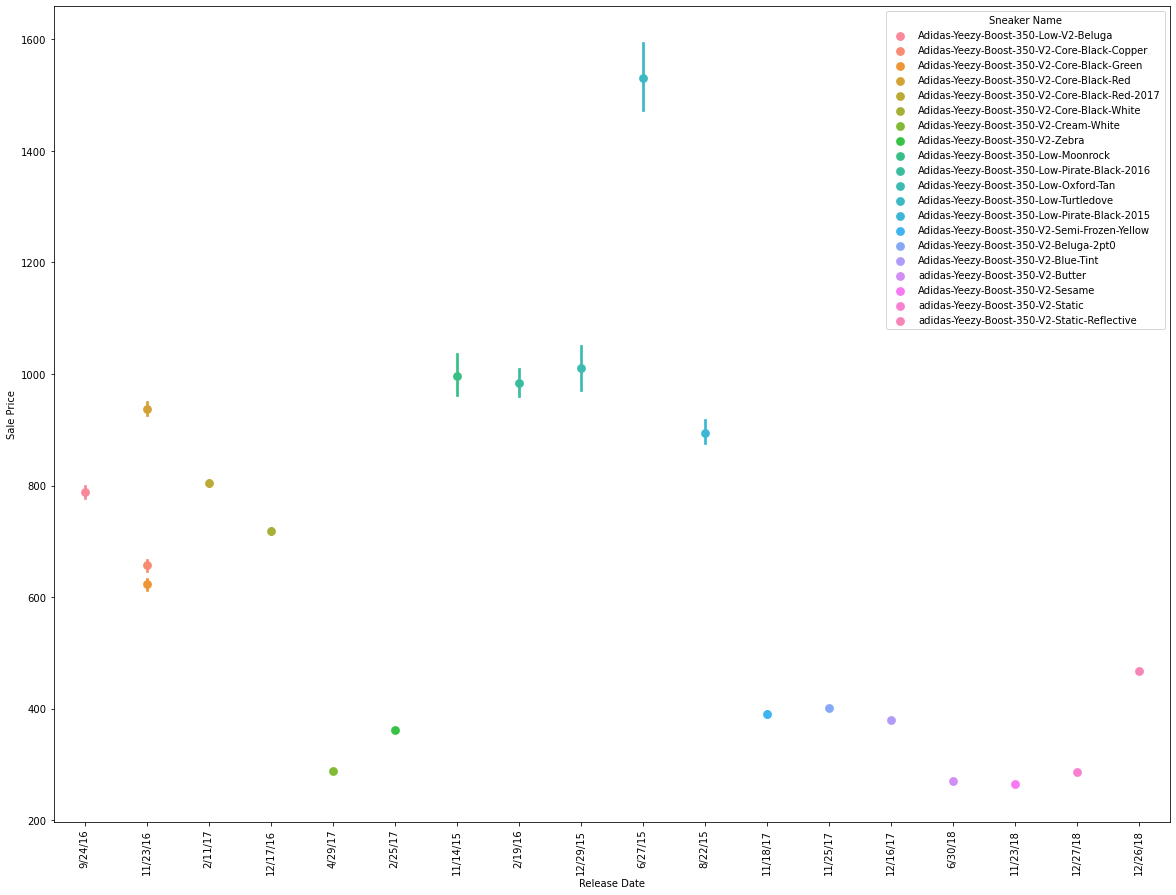

In [24]:
#Creating a point plot of Release date vs Profit
fig, axs = plt.subplots(ncols=1, figsize=(20,15))

sns.pointplot(x="Release Date", y="Sale Price", hue="Sneaker Name", data=yeezy_stockx)
plt.xticks(rotation=90)

plt.savefig("output_data/Fig5.jpg")

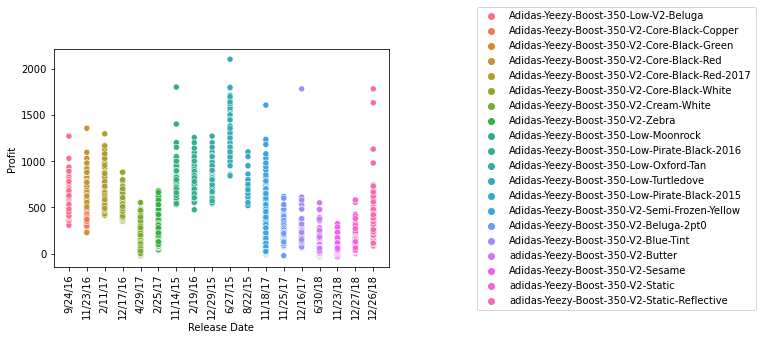

<Figure size 2160x1800 with 0 Axes>

In [26]:
#Creating a point plot of Release date vs Profit for each colorway
ys=sns.scatterplot(x="Release Date", y="Profit", hue="Sneaker Name", data=yeezy_stockx)
plt.xticks(rotation=90)
fig= plt.figure(figsize=(30,25)) 
ys.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

<b>Write-up:<b>

From the information created we can conclude that the summer months tend to generate the highest profit for the "Yeezy Boost 350" sneakers.

If someone is trying to sell their sneakers and get the most revenue from them, they might want to wait until the summer time.

On the other end; a person who is trying to buy these sneakers and doesn't want to spend a huge amount of money, might have more luck in the winter/fall months.

Additional analysis that could help would be to see if there is a correlation between profit, release date and when Kanye West is trending in social media/news.

Kanye West has appeared more frequently in the news over the past couple of years, it might be helpful to see if those trends had a negative or positive impact on sales. 